In [139]:
# pwd = "/Users/youtao/code"
pwd = "/scratch/ty296"
hdf5_data_path = '/scratch/ty296/hdf5_data/'
groupname = 'L'
p_fixed_name = 'p_ctrl'
p_fixed_value = 0.4
import os
print(os.getcwd())
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
import h5py
import numpy as np

/scratch/ty296


In [177]:
from read_hdf5_func import von_neumann_entropy_sv
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error
import glob
import matplotlib.pyplot as plt
import tqdm
# filename = '/scratch/ty296/hdf5_data/p_ctrl0.4/p_proj1.0/6_a0_L20_p_proj1.0.h5'
filename = '/scratch/ty296/test_output/146_a0_L20_p_proj1.0.h5'

def parse_name(name):
    L = int(name.split('_')[2].split('L')[1])
    p_ctrl = float(name.split('_')[3].split('pctrl')[1].split('_')[0])
    p_proj = float(name.split('_')[4].split('pproj')[1].split('_')[0])
    seed = int(name.split('_')[5].split('seed')[1])
    return L, p_ctrl, p_proj, seed

def plot_sv_arr(filename):
    # the input filename must be full file path to a single trajectory h5 file
    with h5py.File(filename, 'r') as f:
        sv_arr = f['singular_values'][:]
        # print(sv_arr)
        plt.yscale('log')
        plt.plot(sv_arr)
        # plt.show()
        plt.savefig(f'/scratch/ty296/plots/sv_arr_{filename}.png')
        # print(sv_arr.shape)

def combine(combined_sv_filename):
    all_files = glob.glob(os.path.join("/scratch/ty296/hdf5_data/p_ctrl0.4", "*", "**"))
    with h5py.File(combined_sv_filename, 'w') as f_target:
        for filename in all_files:
            with h5py.File(filename, 'r+') as f_source:
                dataset = f_source['singular_values']
                # print(len(dataset[:]))
                attrs = dataset.attrs
                # print(attrs.keys())
                dataset_target = f_target.create_dataset(f'sv_arr_L{attrs["L"]}_pctrl{attrs["p_ctrl"]}_pproj{attrs["p_proj"]}_seed{attrs["seed"]}', data=dataset[:])
                dataset_target.attrs.update(attrs)

def total_s0_dict(combined_sv_filename, threshold_val):

    # with h5py.File(sv_combined, 'r') as f:
    # from collections import defaultdict
    # groups = defaultdict(list)
    # for real_key in tqdm.tqdm(f.keys()):
    #     s0 = von_neumann_entropy_sv(f[real_key][()], n=n, positivedefinite=False, threshold=threshold)
    #     # print(f[real_key].attrs['p_proj'],f[real_key].attrs['p_ctrl'],f[real_key].attrs['L'],f[real_key].attrs['maxbond'],s0)
    #     key_val = (f[real_key].attrs['L'],f[real_key].attrs['p_ctrl'],f[real_key].attrs['p_proj'])
    #     groups[key_val].append(s0)

    total_dict = {}
    with h5py.File(combined_sv_filename, 'r') as f:
        for key in list(f.keys()):
            L, p_ctrl, p_proj, seed = parse_name(key)
            if f[key][()].ndim == 1:
                s = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=threshold_val)
            else:
                s = []
                for sv_arr in f[key][()].shape[0]:
                    s.append(von_neumann_entropy_sv(sv_arr, n=0, positivedefinite=False, threshold=threshold_val))
                s = np.array(s)
            
            if (L, p_ctrl, p_proj) not in total_dict:
                total_dict[(L, p_ctrl, p_proj)] = [s]
            else:
                total_dict[(L, p_ctrl, p_proj)].append(s)
    return total_dict

# read into the combined data file
def distribution_dict(combined_sv_filename, L_target, threshold_val):
    min_sv_dict = {}
    maxbond_dict = {}
    entropy_dict = {}
    with h5py.File(combined_sv_filename, 'r') as f:
        for key in list(f.keys()):
            L, p_ctrl, p_proj, seed = parse_name(key)
            if L == L_target:
                if f[key][()].ndim == 1:
                    min_sv = np.min(f[key][()])
                else:
                    min_sv = []
                    for sv_arr in f[key][()].shape[0]:
                        min_sv.append(np.min(sv_arr))
                    min_sv = np.array(min_sv)
                
                if (L, p_ctrl, p_proj) not in min_sv_dict:
                    min_sv_dict[(L, p_ctrl, p_proj)] = [min_sv]
                else:
                    min_sv_dict[(L, p_ctrl, p_proj)].append(min_sv)
            
                if 'maxbond' in f[key].attrs.keys():
                    maxbond = f[key].attrs['maxbond']
                    if (L, p_ctrl, p_proj) not in maxbond_dict:
                        maxbond_dict[(L, p_ctrl, p_proj)] = [maxbond]
                    else:
                        maxbond_dict[(L, p_ctrl, p_proj)].append(maxbond)

                entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=threshold_val)
                if (L, p_ctrl, p_proj) not in entropy_dict:
                    entropy_dict[(L, p_ctrl, p_proj)] = [entropy]
                else:
                    entropy_dict[(L, p_ctrl, p_proj)].append(entropy)
    return min_sv_dict, maxbond_dict, entropy_dict

def plot_distribution(data_dict, n_plots=12, x_label='s0'):
    n_plots = 12
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    # Plot histogram for each p_proj value

    # for idx, (p_proj, sv_seed_list) in enumerate(sorted(min_sv_dict.items())[0:n_plots]):
    for idx, (key, data_array) in enumerate(sorted(data_dict.items())[0:n_plots]):
        print(key, len(data_array))
        L, p_ctrl, p_proj = key
        ax = axes[idx]
        ax.hist(data_array, edgecolor='black')
        ax.set_title(f'p_proj = {p_proj:.2f}')
        ax.set_xlabel(x_label) # chosen from min_sv, maxbond or entropy
        ax.set_ylabel('Count')
        ax.legend()

    # Remove any empty subplots
    for idx in range(len(data_dict), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.savefig(f'/scratch/ty296/plots/distribution_{x_label}.png')
    # plt.show()

import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

def plot_from_dict(total_dict, threshold_val, p_fixed_name='p_ctrl', p_fixed_value=0.4, save_folder='/scratch/ty296/plots'):
    """
    Plot p_proj vs mean±SEM and p_proj vs variance±SEVAR from dictionary
    data_dict format: {(L, p_ctrl, p_proj): (mean, sem, var, semvar)}
    """
    import os
    import numpy as np
    
    # Create save folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    plot_dict = {}
    for key in total_dict.keys():
        if len(total_dict[key]) > 1:
            mean, sem = calculate_mean_and_error(total_dict[key])
            var, semvar = calculate_variance_and_error(total_dict[key])
            plot_dict[key] = (mean, sem, var, semvar)
        else:
            print(key, total_dict[key])

    
    # Filter data for the fixed parameter and organize by L values
    plot_data = {}
    for (L, p_ctrl, p_proj), (mean, sem, var, semvar) in plot_dict.items():
        # Filter based on fixed parameter
        if p_fixed_name == 'p_ctrl' and p_ctrl == p_fixed_value:
            if L not in plot_data:
                plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
            
            plot_data[L]['p_proj'].append(p_proj)
            plot_data[L]['mean'].append(mean)
            plot_data[L]['sem'].append(sem)
            plot_data[L]['variance'].append(var)
            plot_data[L]['se_var'].append(semvar)
        elif p_fixed_name == 'p_proj' and p_proj == p_fixed_value:
            if L not in plot_data:
                plot_data[L] = {'p_ctrl': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
            
            plot_data[L]['p_ctrl'].append(p_ctrl)
            plot_data[L]['mean'].append(mean)
            plot_data[L]['sem'].append(sem)
            plot_data[L]['variance'].append(var)
            plot_data[L]['se_var'].append(semvar)

    if not plot_data:
        print(f"No data found for {p_fixed_name}={p_fixed_value}")
        return

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted L values and create color map
    L_values = sorted(plot_data.keys())
    n_L = len(L_values)
    
    # Create increasingly deeper shades of blue proportional to L value
    colors = []
    if n_L > 1:
        min_L = min(L_values)
        max_L = max(L_values)
        
        for L in L_values:
            # Normalize L to range [0, 1]
            norm_L = (L - min_L) / (max_L - min_L)
            
            # Create light blue to dark blue gradient
            red = 0.7 * (1 - norm_L)      # From 0.7 to 0.0
            green = 0.7 * (1 - norm_L)    # From 0.7 to 0.0  
            blue = 1.0 - 0.2 * norm_L     # From 1.0 to 0.8
            
            blue_color = (red, green, blue)
            colors.append(blue_color)
    else:
        colors = [(0.0, 0.0, 0.8)]  # Single dark blue color

    # Determine x-axis variable and label
    x_var = 'p_proj' if p_fixed_name == 'p_ctrl' else 'p_ctrl'
    x_label = 'p_proj' if p_fixed_name == 'p_ctrl' else 'p_ctrl'

    # Plot 1: x_var vs mean ± sem
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by x variable for cleaner lines
        sorted_indices = np.argsort(data[x_var])
        x_sorted = np.array(data[x_var])[sorted_indices]
        mean_sorted = np.array(data['mean'])[sorted_indices]
        sem_sorted = np.array(data['sem'])[sorted_indices]
        
        ax1.errorbar(x_sorted, mean_sorted, yerr=sem_sorted, 
                    label=f'L={L}', marker='o', capsize=5, capthick=2, color=colors[i])

    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title(f'Mean Entropy vs {x_label} for Different L ({p_fixed_name}={p_fixed_value})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: x_var vs variance ± se_var
    for i, L in enumerate(L_values):
        data = plot_data[L]
        # Sort by x variable for cleaner lines
        sorted_indices = np.argsort(data[x_var])
        x_sorted = np.array(data[x_var])[sorted_indices]
        variance_sorted = np.array(data['variance'])[sorted_indices]
        se_var_sorted = np.array(data['se_var'])[sorted_indices]
        
        ax2.errorbar(x_sorted, variance_sorted, yerr=se_var_sorted, 
                    label=f'L={L}', marker='s', capsize=5, capthick=2, color=colors[i])

    ax2.set_xlabel(x_label)
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title(f'Variance vs {x_label} for Different L ({p_fixed_name}={p_fixed_value})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Save the plot
    save_path = os.path.join(save_folder, f's0_threshold{threshold_val}_{p_fixed_name}{p_fixed_value}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'Plot saved to {save_path}')
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

import pandas as pd

def h5_to_csv(sv_combined, n, threshold: float, save_folder="/scratch/ty296/plots"):
    groups = total_s0_dict(sv_combined, threshold)
    # with h5py.File(sv_combined, 'r') as f:
    #     from collections import defaultdict
    #     groups = defaultdict(list)
    #     for real_key in tqdm.tqdm(f.keys()):
    #         s0 = von_neumann_entropy_sv(f[real_key][()], n=n, positivedefinite=False, threshold=threshold)
    #         # print(f[real_key].attrs['p_proj'],f[real_key].attrs['p_ctrl'],f[real_key].attrs['L'],f[real_key].attrs['maxbond'],s0)
    #         key_val = (f[real_key].attrs['L'],f[real_key].attrs['p_ctrl'],f[real_key].attrs['p_proj'])
    #         groups[key_val].append(s0)
    
    data = []
    for key_val, s0_list in groups.items():
        ensemble_size = len(s0_list)
        # print(f'key_val {key_val} ensemble_size {ensemble_size}')
        mean, sem = calculate_mean_and_error(s0_list)
        if len(s0_list) > 1:
            variance, se_var = calculate_variance_and_error(s0_list)
        else:
            variance, se_var = 0, 0
        # print(key_val, "mean", mean, "sem", sem, "variance", variance, "se_var", se_var)
        data.append(list(key_val) + [mean, sem, variance, se_var])
    # print(data)

    df = pd.DataFrame(data, columns=['L', 'p_ctrl', 'p_proj', 'mean', 'sem', 'variance', 'se_var'])
    # save the data to a csv file
    csv_path = os.path.join(save_folder, f's{n}_threshold{threshold:.1e}_{p_fixed_name}{p_fixed_value}.csv')
    df.to_csv(csv_path, index=False)
    print(f'threadhold {threshold} saved to {csv_path}')

    return df

In [179]:
from datetime import date
hdf5_combined_data_path = "/scratch/ty296/hdf5_data_combined"
combined_sv_filename = os.path.join(hdf5_combined_data_path, f"sv_combined_{p_fixed_name}{p_fixed_value}_{date.today()}.h5")
# read into the combined data file
threshold_val = 1e-8
total_dict = total_s0_dict(combined_sv_filename, threshold_val)


(16, 0.4, 0.5)


In [183]:
n = 0
h5_to_csv(combined_sv_filename, n, threshold_val)

/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


threadhold 1e-08 saved to /scratch/ty296/plots/s0_threshold1.0e-08_p_ctrl0.4.csv


,L,p_ctrl,p_proj,mean,sem,variance,se_var
0,16,0.4,0.50,2.738322,0.033380,1.113132,2.123964e-03
1,16,0.4,0.60,2.420516,0.031676,1.002378,1.647838e-03
2,16,0.4,0.70,1.930685,0.031041,0.963524,1.269119e-03
3,16,0.4,0.80,1.360977,0.027888,0.777764,8.271010e-04
4,16,0.4,0.90,0.683843,0.021281,0.452879,4.295423e-04
5,16,0.4,1.00,0.000000,0.000000,0.000000,0.000000e+00
6,20,0.4,0.55,3.385368,0.055766,1.533144,8.934635e-03
7,20,0.4,0.50,3.633485,0.037065,1.357311,3.839829e-03
8,20,0.4,0.65,2.712505,0.049847,1.227437,4.767035e-03
9,20,0.4,0.60,3.063892,0.037985,1.426996,3.645779e-03


In [196]:
def fixed_L_threshold_comparison_plot(save_folder: str, L: int, n: int, p_fixed_name: str, p_fixed_value: float):
    """
    Plot the comparison of the entropy for different thresholds
    """
    
    # Read from csv files
    csv_paths = glob.glob(os.path.join(save_folder, f's{n}_threshold*_{p_fixed_name}{p_fixed_value}.csv'))
    
    # Organize data by threshold values
    plot_data = {}
    import re
    
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        # Find data specific to L
        df_L = df[df['L'] == L]
        
        if len(df_L) == 0:
            continue
            
        # Extract threshold from csv_path filename
        threshold_match = re.search(r'threshold([\d\.e\-\+]+)', csv_path)
        if threshold_match:
            threshold_str = threshold_match.group(1)
            threshold_val = float(threshold_str)
        else:
            continue
            
        # Sort by p_proj and get corresponding values
        sorted_indices = np.argsort(df_L['p_proj'])
        plot_data[threshold_val] = {
            'p_proj': df_L['p_proj'].iloc[sorted_indices].values,
            'mean': df_L['mean'].iloc[sorted_indices].values,
            'sem': df_L['sem'].iloc[sorted_indices].values,
            'variance': df_L['variance'].iloc[sorted_indices].values,
            'se_var': df_L['se_var'].iloc[sorted_indices].values
        }

    # Create plots with same formatting as plot_from_csv
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Get sorted threshold values and create color map
    threshold_values = sorted(plot_data.keys())
    n_thresholds = len(threshold_values)
    
    # Create increasingly deeper shades of blue proportional to threshold value
    colors = []
    if n_thresholds > 1:
        min_thresh = min(threshold_values)
        max_thresh = max(threshold_values)
        
        for thresh in threshold_values:
            # Normalize threshold to range [0, 1]
            norm_thresh = (thresh - min_thresh) / (max_thresh - min_thresh)
            
            # Create dark blue to light blue gradient
            # Lowest threshold (norm_thresh=0) -> dark blue (0.0, 0.0, 0.8)
            # Highest threshold (norm_thresh=1) -> light blue (0.7, 0.7, 1.0)
            red = 0.7 * norm_thresh            # From 0.0 to 0.7
            green = 0.7 * norm_thresh          # From 0.0 to 0.7  
            blue = 0.8 + 0.2 * norm_thresh     # From 0.8 to 1.0
            
            blue_color = (red, green, blue)
            colors.append(blue_color)
    else:
        colors = [(0.0, 0.0, 0.8)]  # Single dark blue color

    # Plot 1: p_proj vs mean ± sem
    for i, threshold in enumerate(threshold_values):
        data = plot_data[threshold]
        min_ = abs(np.log(sorted(threshold_values, reverse=True)[0]))
        max_ = abs(np.log(min(threshold_values)))
        alpha = (abs(np.log(threshold))-min_)/(max_-min_)
        ax1.errorbar(data['p_proj'], data['mean'], yerr=data['sem'], 
                    label=f'threshold={threshold:.1e}', marker='o', capsize=5, capthick=2, color='blue', alpha=alpha)

    ax1.set_xlabel('p_proj')
    ax1.set_ylabel('Mean Entropy ± SEM')
    ax1.set_title(f'Mean Entropy vs p_proj for L={L}')
    ax1.legend()
    # ax1.set_xlim(0.2, 1.0)
    ax1.grid(True, alpha=0.3)

    # Plot 2: p_proj vs variance ± se_var
    for i, threshold in enumerate(threshold_values):
        data = plot_data[threshold]
        min_ = abs(np.log(sorted(threshold_values, reverse=True)[0]))
        max_ = abs(np.log(min(threshold_values)))
        alpha = (abs(np.log(threshold))-min_)/(max_-min_)
        ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'], 
                    label=f'threshold={threshold:.1e}', marker='s', capsize=5, capthick=2, color='blue', alpha=alpha)

    ax2.set_xlabel('p_proj')
    ax2.set_ylabel('Variance ± SEVar')
    ax2.set_title(f'Variance vs p_proj for L={L}')
    ax2.legend()
    # ax2.set_xlim(0.2, 1.0)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    # plt.savefig(f'{save_folder}/s{n}_threshold_comparison_{L}.png')
    plt.show()
    # plt.close()
    print(f'Threshold comparison for L={L} saved to {save_folder}/s{n}_threshold_comparison_{L}.png')

In [193]:
n = 0
for threshold_val in np.logspace(-15, -5, 10):
    h5_to_csv(combined_sv_filename, n, threshold_val)

/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


threadhold 1e-15 saved to /scratch/ty296/plots/s0_threshold1.0e-15_p_ctrl0.4.csv
threadhold 1.2915496650148826e-14 saved to /scratch/ty296/plots/s0_threshold1.3e-14_p_ctrl0.4.csv
threadhold 1.6681005372000557e-13 saved to /scratch/ty296/plots/s0_threshold1.7e-13_p_ctrl0.4.csv
threadhold 2.1544346900318868e-12 saved to /scratch/ty296/plots/s0_threshold2.2e-12_p_ctrl0.4.csv
threadhold 2.7825594022071258e-11 saved to /scratch/ty296/plots/s0_threshold2.8e-11_p_ctrl0.4.csv
threadhold 3.593813663804626e-10 saved to /scratch/ty296/plots/s0_threshold3.6e-10_p_ctrl0.4.csv
threadhold 4.641588833612792e-09 saved to /scratch/ty296/plots/s0_threshold4.6e-09_p_ctrl0.4.csv
threadhold 5.994842503189421e-08 saved to /scratch/ty296/plots/s0_threshold6.0e-08_p_ctrl0.4.csv
threadhold 7.742636826811278e-07 saved to /scratch/ty296/plots/s0_threshold7.7e-07_p_ctrl0.4.csv
threadhold 1e-05 saved to /scratch/ty296/plots/s0_threshold1.0e-05_p_ctrl0.4.csv


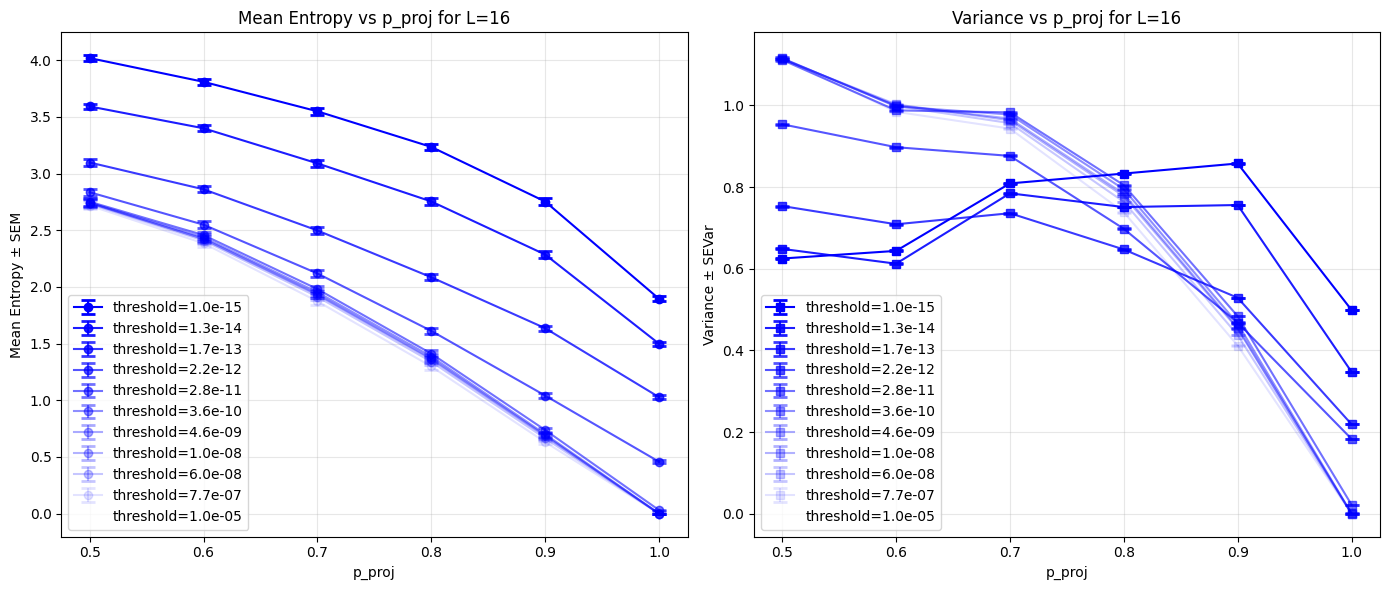

Threshold comparison for L=16 saved to /scratch/ty296/plots/s0_threshold_comparison_16.png


In [198]:
L_target = 16
fixed_L_threshold_comparison_plot("/scratch/ty296/plots", L_target, n, p_fixed_name, p_fixed_value)

Found L values: [8, 16, 20, 24]
Found p_ctrl values: [0.4]
Found p_proj values: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


Plot saved to /scratch/ty296/CT_MPS_mini/plots/entropy_vs_pproj_pctrl0.4.png


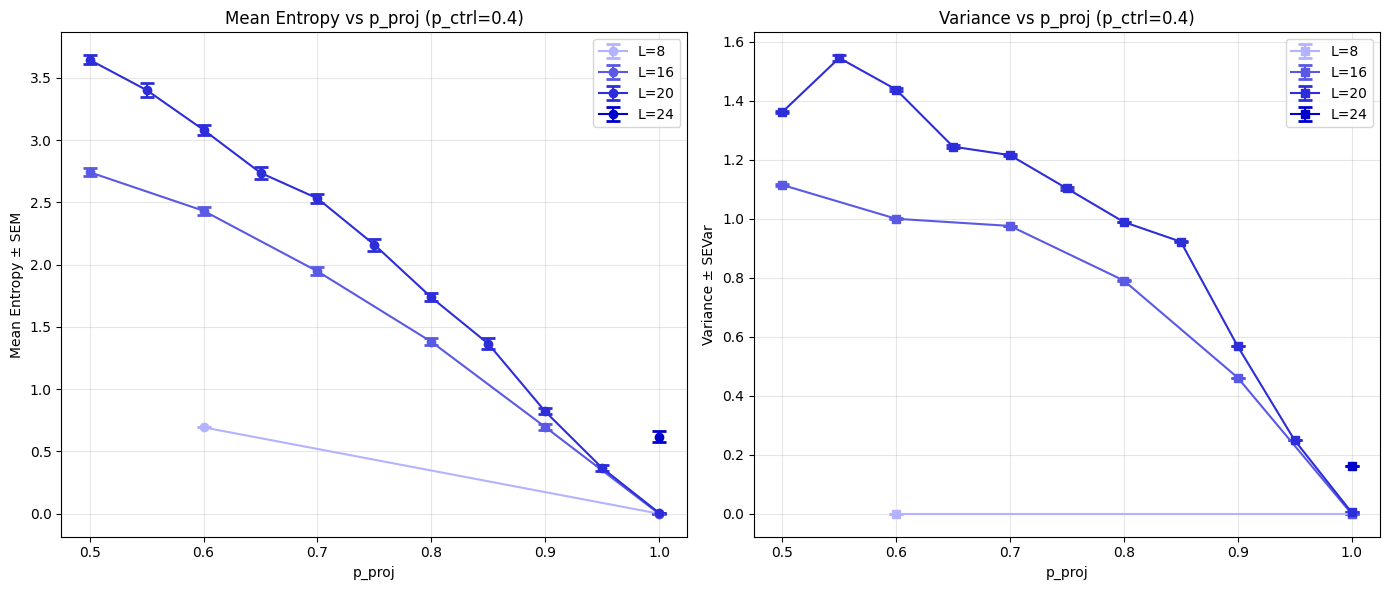

Plot saved to /scratch/ty296/CT_MPS_mini/plots/entropy_vs_pctrl_pproj0.75.png


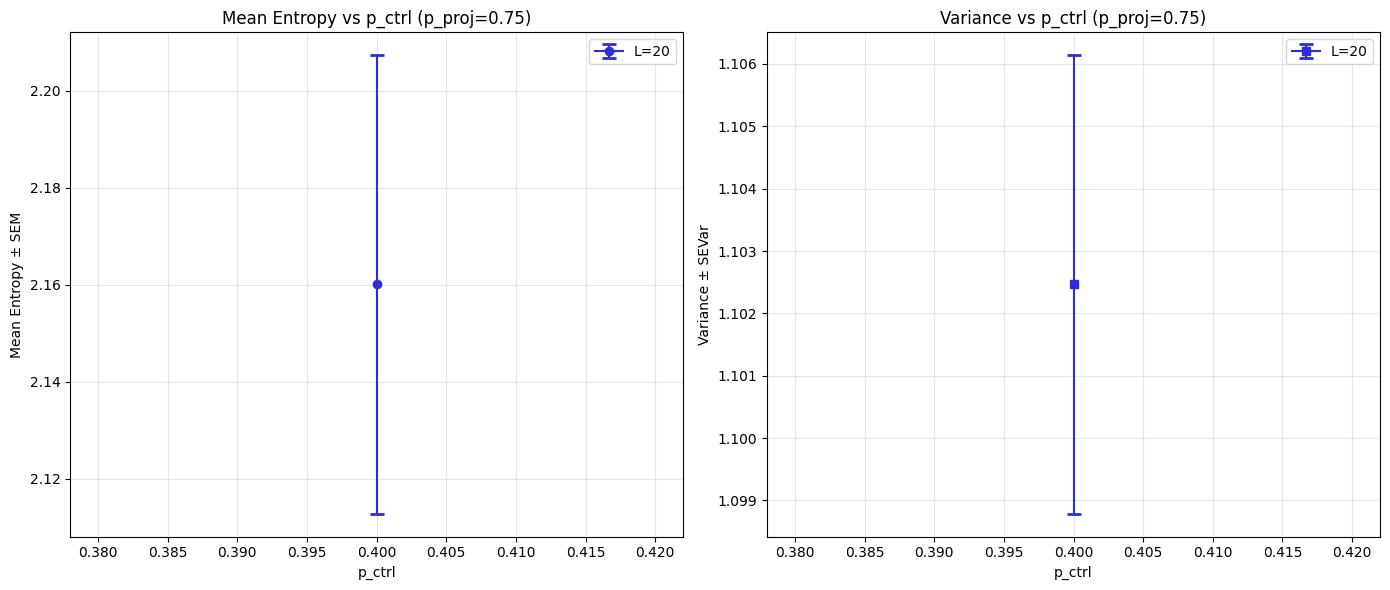

In [149]:
# Alternative plotting function with more flexibility
def plot_entropy_analysis(data_dict, save_folder='/scratch/ty296/CT_MPS_mini/plots'):
    """
    Create comprehensive entropy analysis plots from dictionary
    data_dict format: {(L, p_ctrl, p_proj): (mean, sem, var, semvar)}
    
    Creates multiple plots:
    1. Mean entropy vs p_proj for different L values (fixed p_ctrl)
    2. Variance vs p_proj for different L values (fixed p_ctrl)  
    3. Mean entropy vs p_ctrl for different L values (fixed p_proj)
    4. Variance vs p_ctrl for different L values (fixed p_proj)
    """
    import os
    import numpy as np
    
    # Create save folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)
    
    # Extract unique values
    L_values = sorted(set(key[0] for key in data_dict.keys()))
    p_ctrl_values = sorted(set(key[1] for key in data_dict.keys()))
    p_proj_values = sorted(set(key[2] for key in data_dict.keys()))
    
    print(f"Found L values: {L_values}")
    print(f"Found p_ctrl values: {p_ctrl_values}")
    print(f"Found p_proj values: {p_proj_values}")
    
    # Color scheme for L values
    def get_colors(values):
        colors = []
        if len(values) > 1:
            min_val = min(values)
            max_val = max(values)
            
            for val in values:
                # Normalize to range [0, 1]
                norm_val = (val - min_val) / (max_val - min_val)
                
                # Create light blue to dark blue gradient
                red = 0.7 * (1 - norm_val)      # From 0.7 to 0.0
                green = 0.7 * (1 - norm_val)    # From 0.7 to 0.0  
                blue = 1.0 - 0.2 * norm_val     # From 1.0 to 0.8
                
                colors.append((red, green, blue))
        else:
            colors = [(0.0, 0.0, 0.8)]  # Single dark blue color
        return colors
    
    colors = get_colors(L_values)
    
    # Plot 1 & 2: vs p_proj for different L (fix p_ctrl to middle value)
    if len(p_ctrl_values) > 0:
        p_ctrl_fixed = p_ctrl_values[len(p_ctrl_values)//2]  # Use middle value
        
        # Organize data by L
        plot_data_pproj = {}
        for (L, p_ctrl, p_proj), (mean, sem, var, semvar) in data_dict.items():
            if p_ctrl == p_ctrl_fixed:
                if L not in plot_data_pproj:
                    plot_data_pproj[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
                
                plot_data_pproj[L]['p_proj'].append(p_proj)
                plot_data_pproj[L]['mean'].append(mean)
                plot_data_pproj[L]['sem'].append(sem)
                plot_data_pproj[L]['variance'].append(var)
                plot_data_pproj[L]['se_var'].append(semvar)
        
        if plot_data_pproj:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot mean vs p_proj
            for i, L in enumerate(sorted(plot_data_pproj.keys())):
                data = plot_data_pproj[L]
                sorted_indices = np.argsort(data['p_proj'])
                x_sorted = np.array(data['p_proj'])[sorted_indices]
                mean_sorted = np.array(data['mean'])[sorted_indices]
                sem_sorted = np.array(data['sem'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax1.errorbar(x_sorted, mean_sorted, yerr=sem_sorted, 
                            label=f'L={L}', marker='o', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax1.set_xlabel('p_proj')
            ax1.set_ylabel('Mean Entropy ± SEM')
            ax1.set_title(f'Mean Entropy vs p_proj (p_ctrl={p_ctrl_fixed})')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot variance vs p_proj
            for i, L in enumerate(sorted(plot_data_pproj.keys())):
                data = plot_data_pproj[L]
                sorted_indices = np.argsort(data['p_proj'])
                x_sorted = np.array(data['p_proj'])[sorted_indices]
                var_sorted = np.array(data['variance'])[sorted_indices]
                se_var_sorted = np.array(data['se_var'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax2.errorbar(x_sorted, var_sorted, yerr=se_var_sorted, 
                            label=f'L={L}', marker='s', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax2.set_xlabel('p_proj')
            ax2.set_ylabel('Variance ± SEVar')
            ax2.set_title(f'Variance vs p_proj (p_ctrl={p_ctrl_fixed})')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            save_path = os.path.join(save_folder, f'entropy_vs_pproj_pctrl{p_ctrl_fixed}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to {save_path}')
            plt.show()
    
    # Plot 3 & 4: vs p_ctrl for different L (fix p_proj to middle value)
    if len(p_proj_values) > 0:
        p_proj_fixed = p_proj_values[len(p_proj_values)//2]  # Use middle value
        
        # Organize data by L
        plot_data_pctrl = {}
        for (L, p_ctrl, p_proj), (mean, sem, var, semvar) in data_dict.items():
            if p_proj == p_proj_fixed:
                if L not in plot_data_pctrl:
                    plot_data_pctrl[L] = {'p_ctrl': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}
                
                plot_data_pctrl[L]['p_ctrl'].append(p_ctrl)
                plot_data_pctrl[L]['mean'].append(mean)
                plot_data_pctrl[L]['sem'].append(sem)
                plot_data_pctrl[L]['variance'].append(var)
                plot_data_pctrl[L]['se_var'].append(semvar)
        
        if plot_data_pctrl:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Plot mean vs p_ctrl
            for i, L in enumerate(sorted(plot_data_pctrl.keys())):
                data = plot_data_pctrl[L]
                sorted_indices = np.argsort(data['p_ctrl'])
                x_sorted = np.array(data['p_ctrl'])[sorted_indices]
                mean_sorted = np.array(data['mean'])[sorted_indices]
                sem_sorted = np.array(data['sem'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax1.errorbar(x_sorted, mean_sorted, yerr=sem_sorted, 
                            label=f'L={L}', marker='o', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax1.set_xlabel('p_ctrl')
            ax1.set_ylabel('Mean Entropy ± SEM')
            ax1.set_title(f'Mean Entropy vs p_ctrl (p_proj={p_proj_fixed})')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot variance vs p_ctrl
            for i, L in enumerate(sorted(plot_data_pctrl.keys())):
                data = plot_data_pctrl[L]
                sorted_indices = np.argsort(data['p_ctrl'])
                x_sorted = np.array(data['p_ctrl'])[sorted_indices]
                var_sorted = np.array(data['variance'])[sorted_indices]
                se_var_sorted = np.array(data['se_var'])[sorted_indices]
                
                color_idx = L_values.index(L) if L in L_values else 0
                ax2.errorbar(x_sorted, var_sorted, yerr=se_var_sorted, 
                            label=f'L={L}', marker='s', capsize=5, capthick=2, 
                            color=colors[color_idx])
            
            ax2.set_xlabel('p_ctrl')
            ax2.set_ylabel('Variance ± SEVar')
            ax2.set_title(f'Variance vs p_ctrl (p_proj={p_proj_fixed})')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            save_path = os.path.join(save_folder, f'entropy_vs_pctrl_pproj{p_proj_fixed}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f'Plot saved to {save_path}')
            plt.show()

# Run the comprehensive analysis
plot_entropy_analysis(plot_dict)


The latest combine data code ends here; below are old

In [150]:
with h5py.File(filename, 'r') as f:
    L_target = 20
    matching_groups = []
    
    print(f"Searching for groups with L={L_target}...")
    print("=" * 80)
    
    # Loop through all realizations
    for key in f.keys():
        # Check if this group has L=24
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            matching_groups.append(key)
    
    print(f"Found {len(matching_groups)} groups with L={L_target}")
    print()
    
    # # Display information for each matching group
    # for i, key in enumerate(matching_groups):
    #     sv_array = f[key][()]
    #     attrs = dict(f[key].attrs)
        
    #     print(f"Group {i+1}: {key}")
    #     print(f"  L = {attrs.get('L')}")
    #     print(f"  p_ctrl = {attrs.get('p_ctrl')}")
    #     print(f"  p_proj = {attrs.get('p_proj')}")
    #     print(f"  maxbond = {attrs.get('maxbond')}")
    #     print(f"  Singular value array shape: {sv_array.shape}")
    #     print(f"  Singular values: {sv_array}")
    #     print(f"  Max SV: {np.max(sv_array):.6e}")
    #     print(f"  Min SV: {np.min(sv_array):.6e}")
    #     print(f"  Number of SVs: {len(sv_array)}")
    #     print("-" * 60)


Searching for groups with L=20...
Found 1 groups with L=20



In [151]:
# Plot singular values for all L=24 groups
L24_groups = []

with h5py.File(filename, 'r') as f:
    L_target = 20
    
    # Collect all L=24 groups
    for key in f.keys():
        if 'L' in f[key].attrs and f[key].attrs['L'] == L_target:
            L24_groups.append(key)


In [152]:
dict_min_sv = {}
for key in L24_groups[:]:
    with h5py.File(filename, 'r') as f:
        # print(f[key].attrs.keys())
        min_sv = min(f[key][()])
        # print(f[key].attrs.keys())
        p_proj = f[key].attrs['p_proj']
        seed = f[key].attrs['seed']
        if p_proj in dict_min_sv:
            dict_min_sv[p_proj].append((np.log10(min_sv), seed))
        else:
            dict_min_sv[p_proj] = [(np.log10(min_sv), seed)]
        # if min_sv < 1e-10:
        #     print(min_sv, p_proj)

        # print(min_sv.shape)


0 1.0 1


/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ty296/.local/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ZeroDivisionError: division by zero

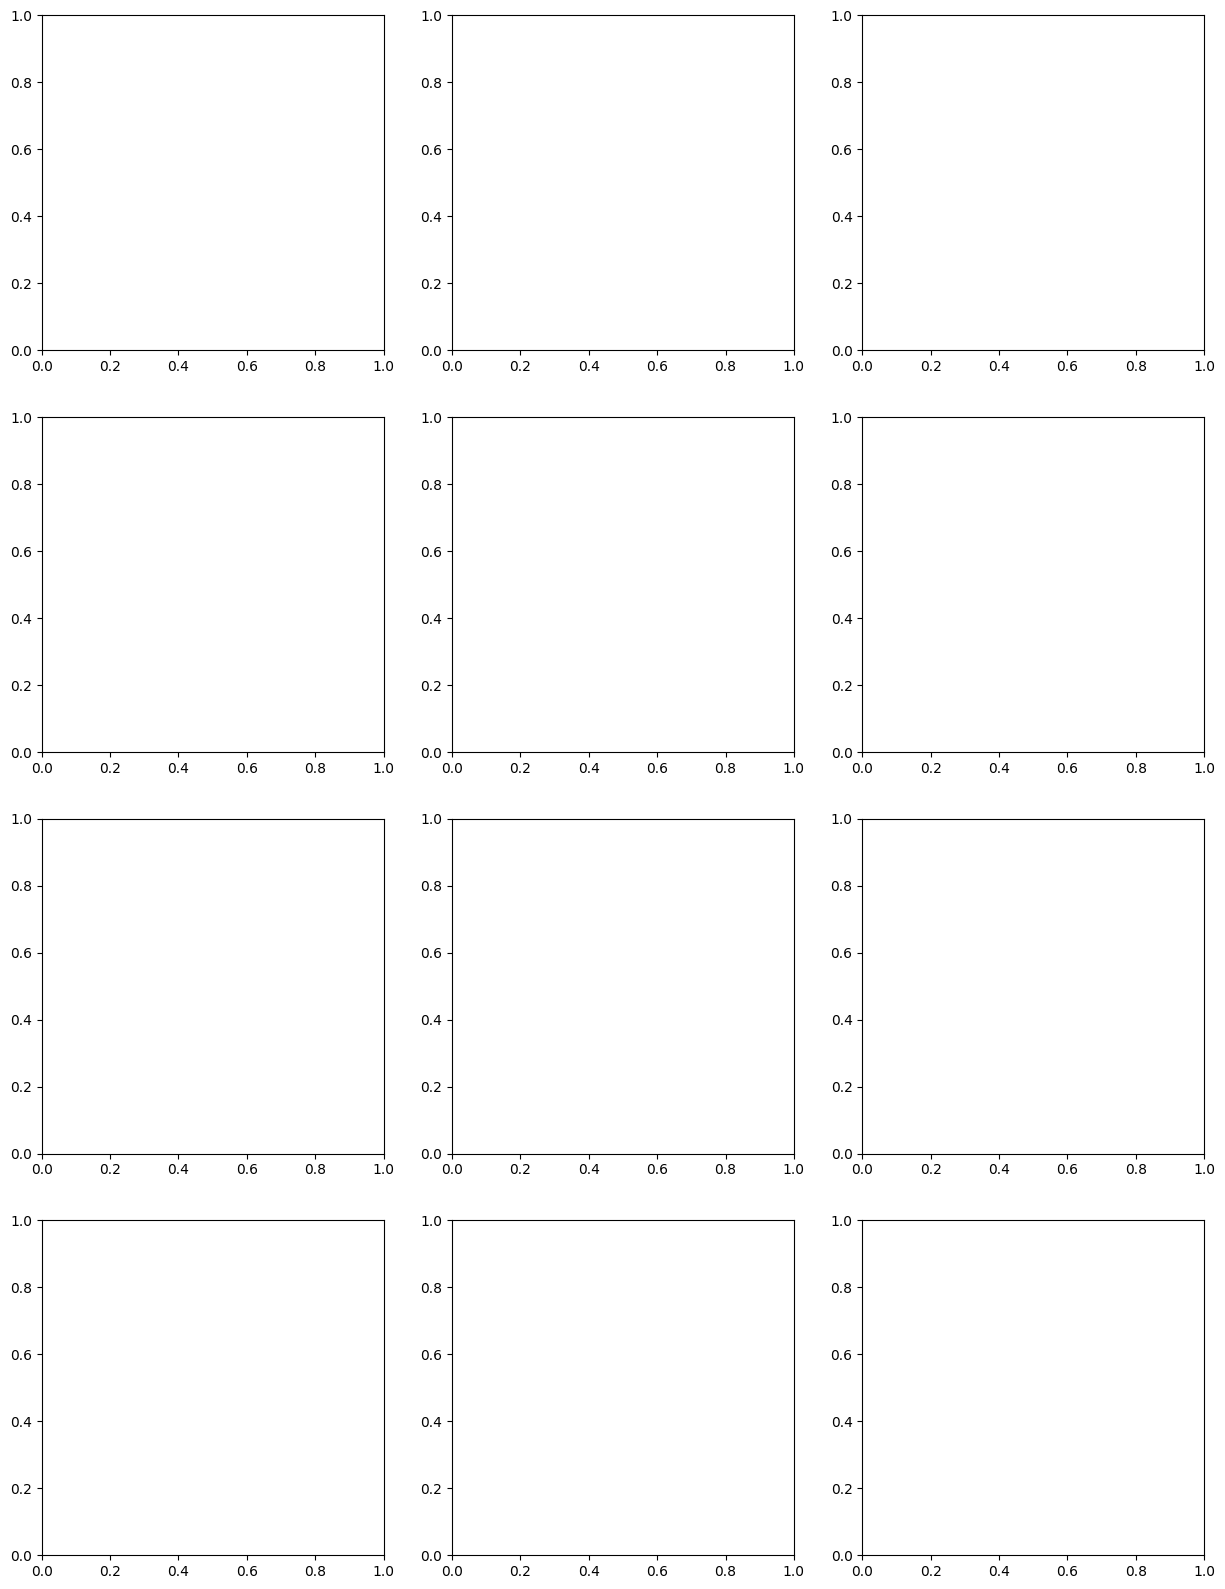

In [154]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = 12
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, sv_seed_list) in enumerate(sorted(dict_min_sv.items())[0:n_plots]):
    # print(idx, p_proj, sv_seed_list)
    min_svs = [sv for sv, seed in sv_seed_list]
    print(idx, p_proj, len(min_svs))
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(min_svs)
    var, semvar = calculate_variance_and_error(min_svs)
    ax.hist(min_svs, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Min SV')
    ax.set_ylabel('Count')
    # ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    # ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    # ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict_min_sv), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
from read_hdf5_func import von_neumann_entropy_sv
dict = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        entropy = von_neumann_entropy_sv(f[key][()], n=0, positivedefinite=False, threshold=1e-15)
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict:
            dict[p_proj].append(entropy)
        else:
            dict[p_proj] = [entropy]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

In [ ]:
print(len(dict))

20


3970 0.2
3970 0.24210526315789474
3970 0.28421052631578947
3988 0.3263157894736842
4000 0.3684210526315789
4000 0.4105263157894737
4000 0.45263157894736844
4000 0.49473684210526314
4000 0.5368421052631579
4000 0.5789473684210527
4000 0.6210526315789474
4000 0.6631578947368421
4000 0.7052631578947368
4000 0.7473684210526316
4000 0.7894736842105263
4000 0.8315789473684211
4000 0.8736842105263158
4000 0.9157894736842105
4000 0.9578947368421052
4000 1.0


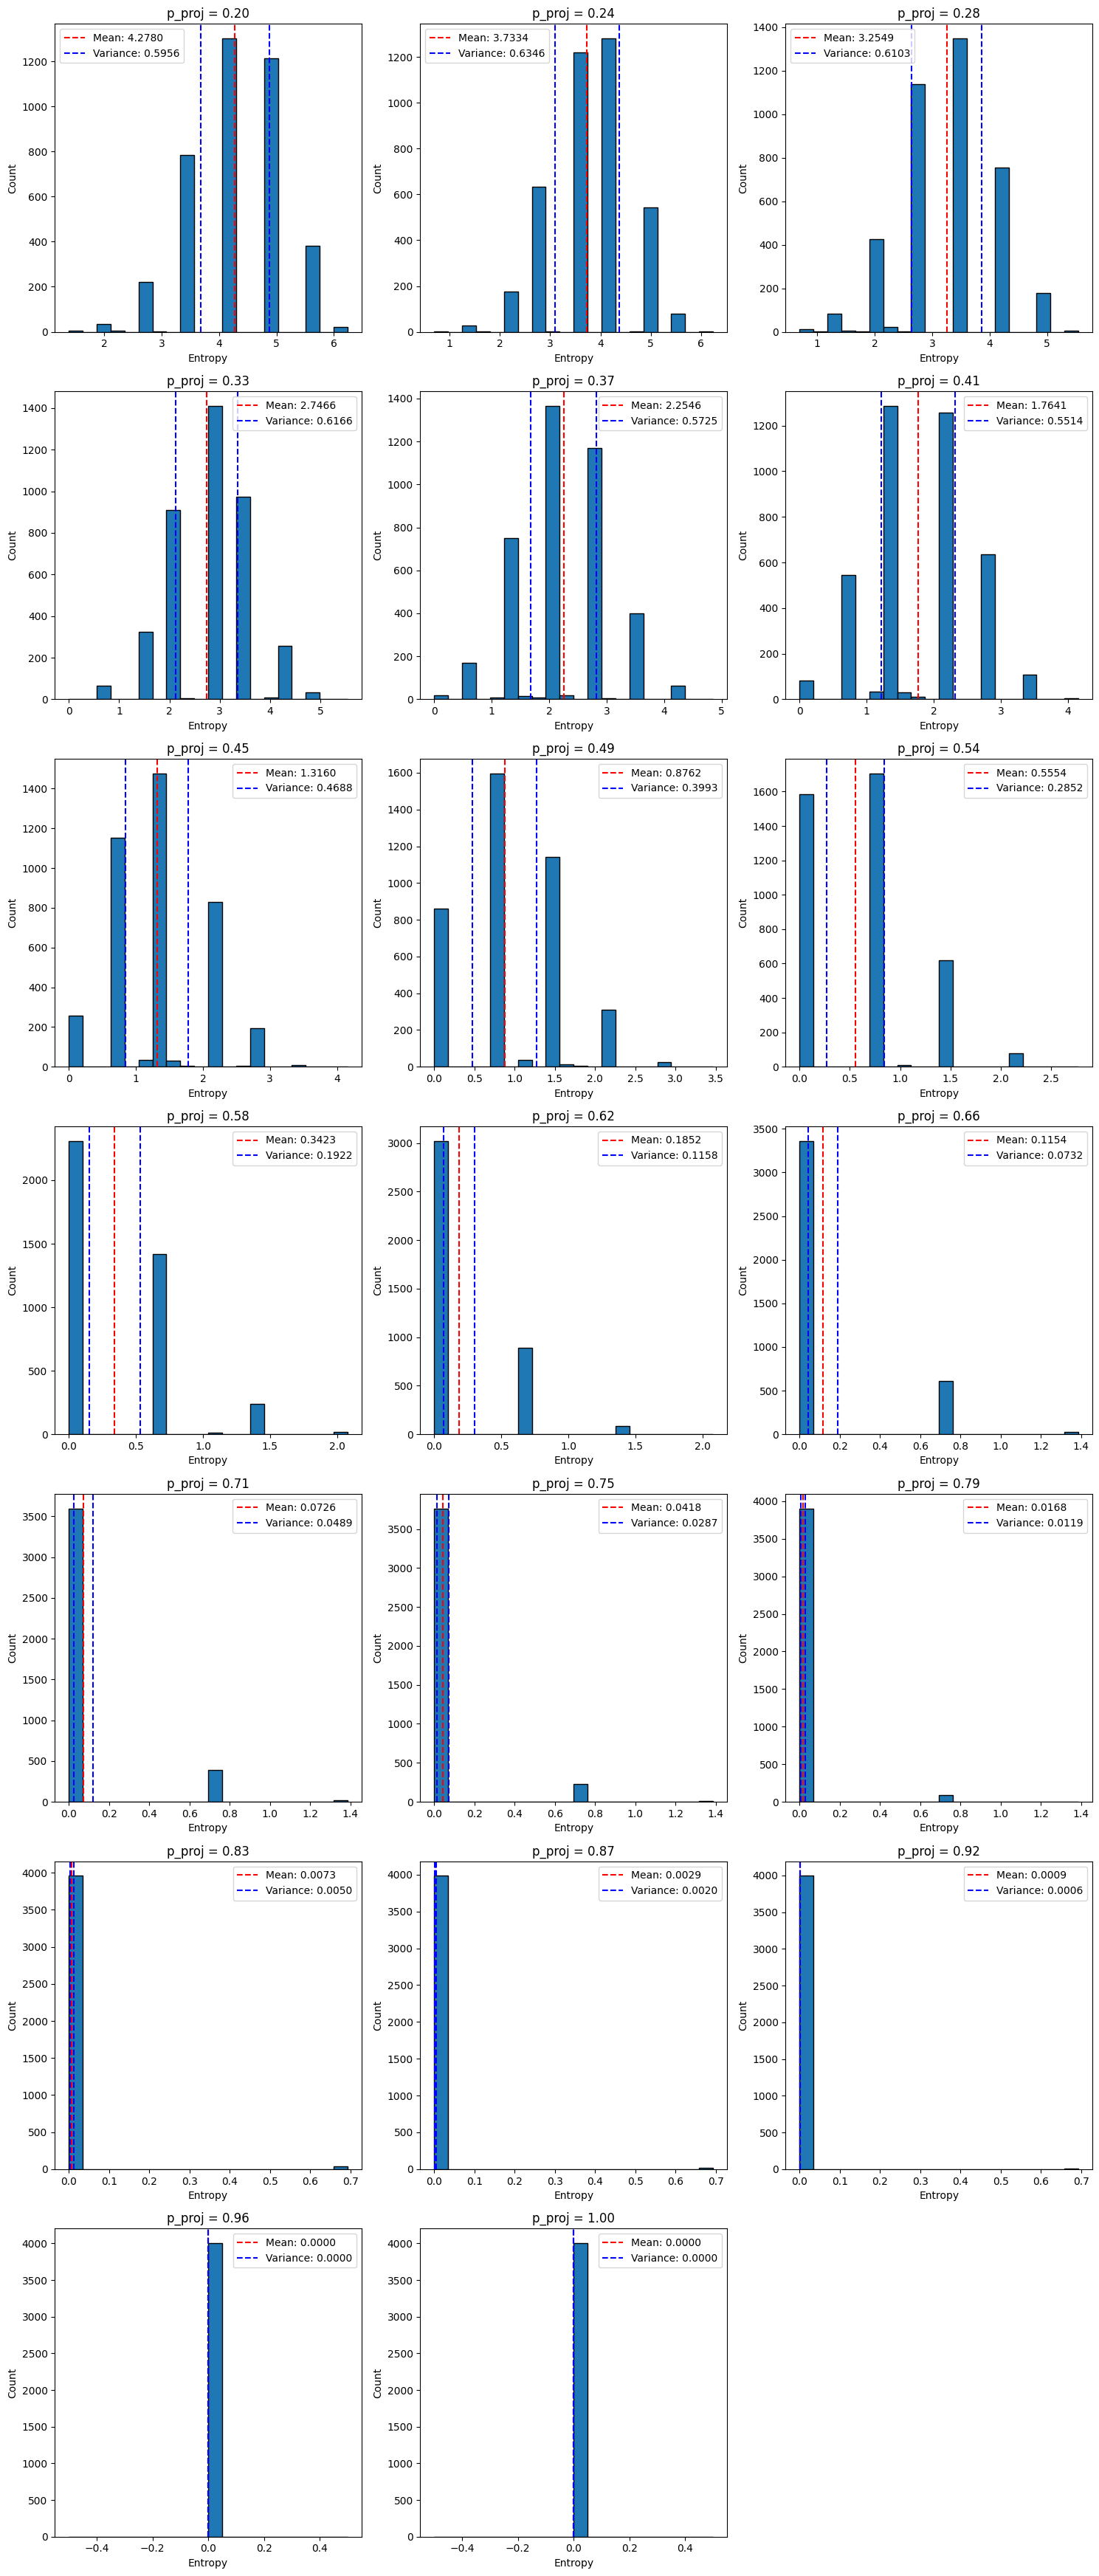

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, entropies) in enumerate(sorted(dict.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(entropies)
    var, semvar = calculate_variance_and_error(entropies)
    print(len(entropies), p_proj)
    ax.hist(entropies, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + var, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - var, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
dict_maxbond = {}
with h5py.File(filename, 'r') as f:
    for key in L24_groups:
        maxbond = f[key].attrs['maxbond']
        p_proj = f[key].attrs['p_proj']
        if p_proj in dict_maxbond:
            dict_maxbond[p_proj].append(maxbond)
        else:
            dict_maxbond[p_proj] = [maxbond]
        # print(entropy)
        # print(f[key].attrs['p_proj'])

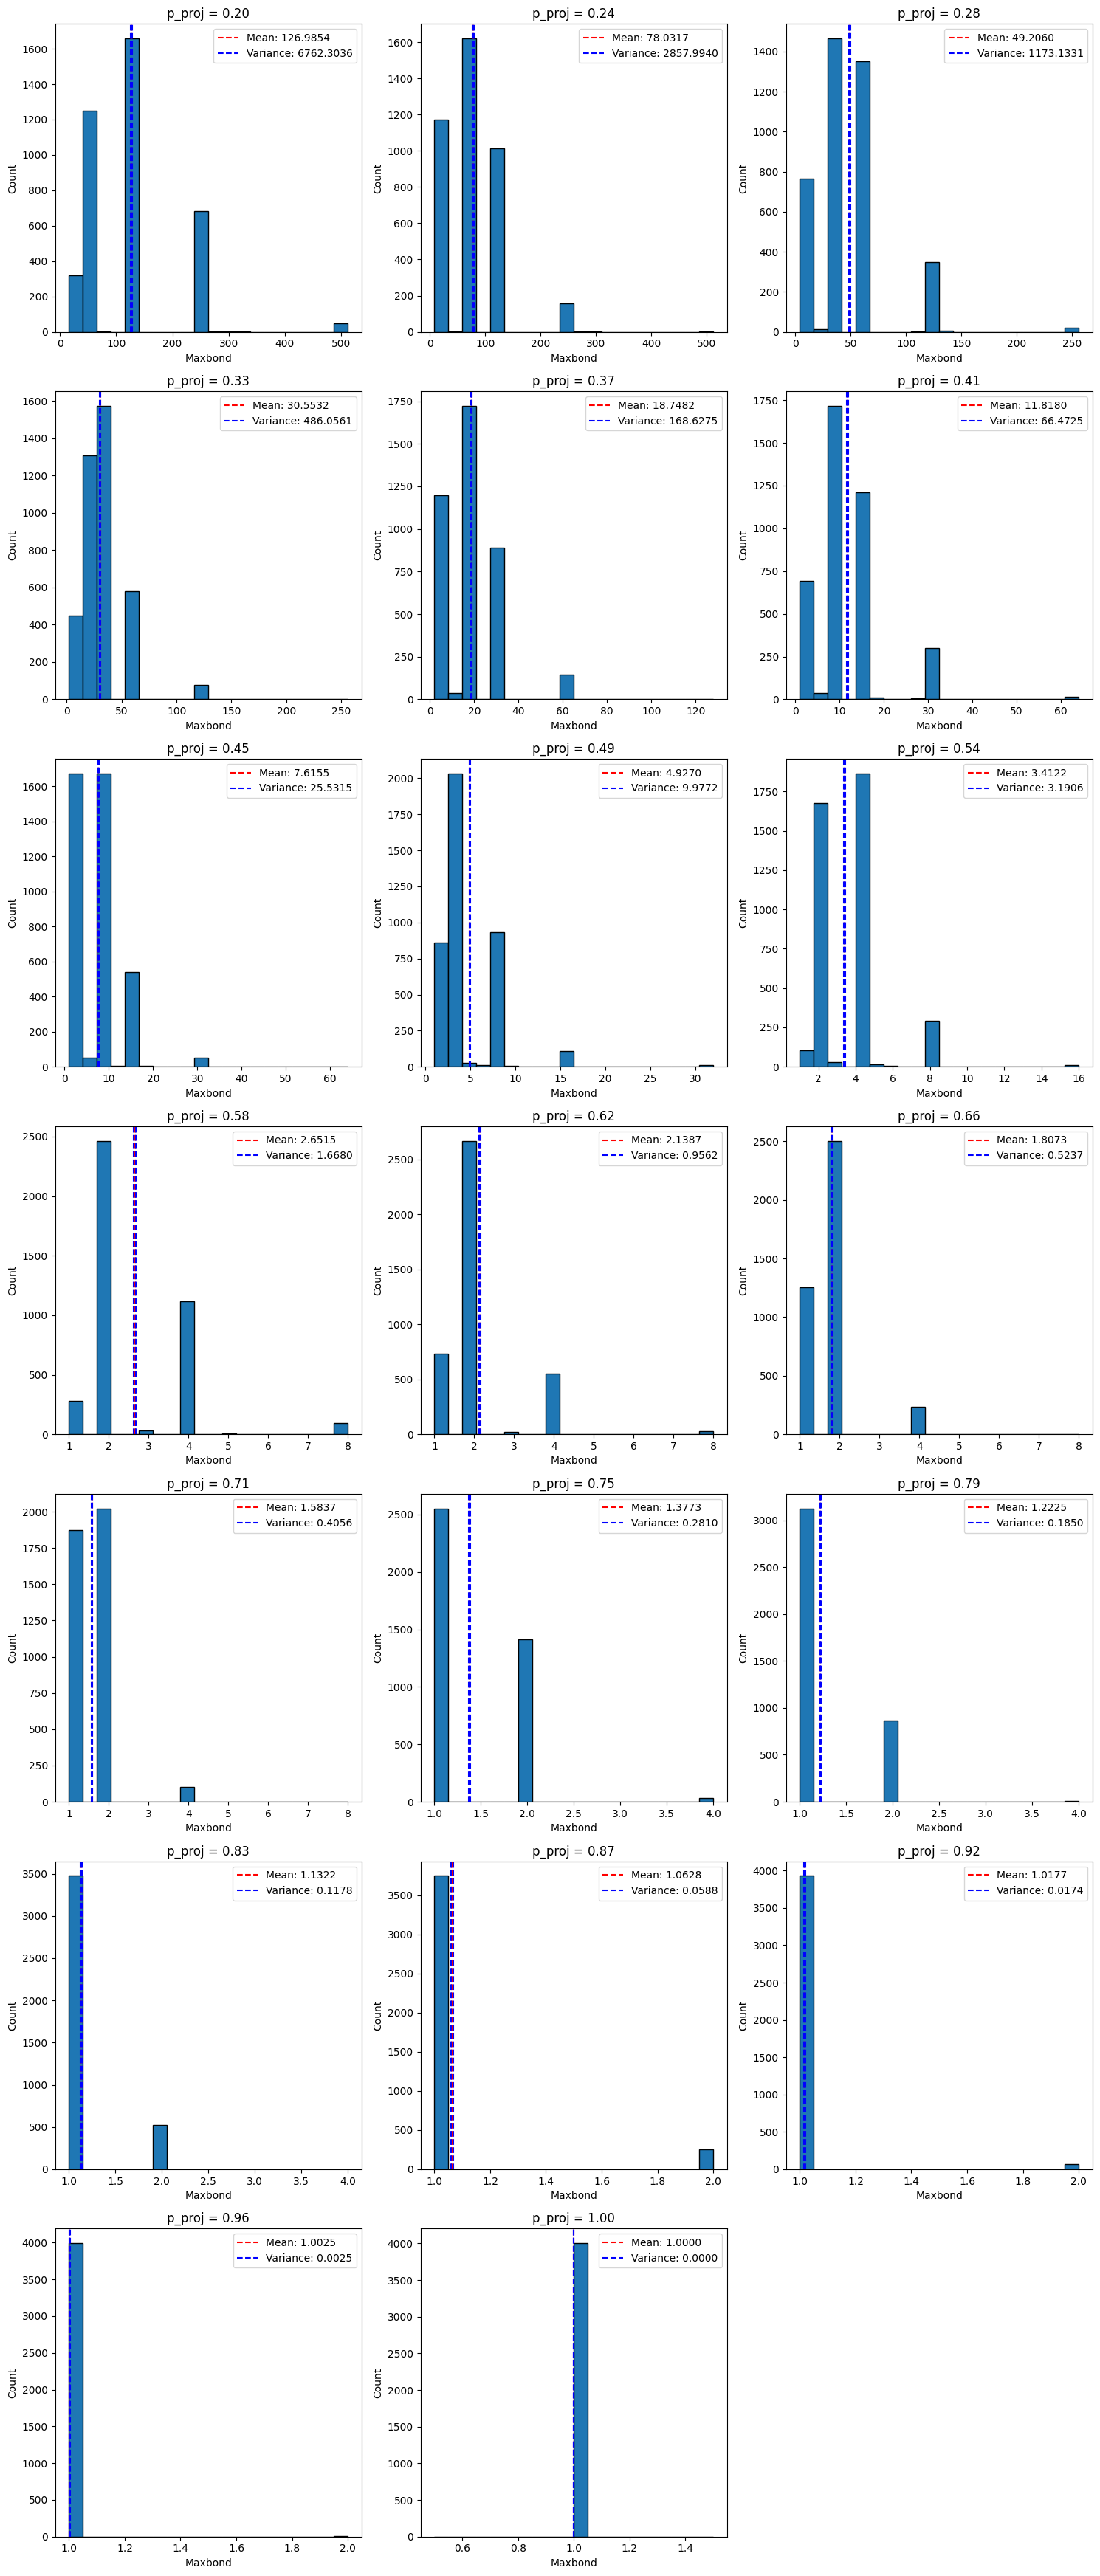

In [ ]:
import matplotlib.pyplot as plt
from read_hdf5_func import calculate_variance_and_error, calculate_mean_and_error

# Create a figure with subplots arranged based on number of p_proj values
n_plots = len(dict_maxbond)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Plot histogram for each p_proj value
for idx, (p_proj, maxbonds) in enumerate(sorted(dict_maxbond.items())):
    ax = axes[idx]
    mean, sem = calculate_mean_and_error(maxbonds)
    var, semvar = calculate_variance_and_error(maxbonds)
    # print(maxbonds)
    ax.hist(maxbonds, bins=20, edgecolor='black')
    ax.set_title(f'p_proj = {p_proj:.2f}')
    ax.set_xlabel('Maxbond')
    ax.set_ylabel('Count')
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.4f}')
    ax.axvline(mean + sem, color='blue', linestyle='--', label=f'Variance: {var:.4f}')
    ax.axvline(mean - sem, color='blue', linestyle='--')
    ax.legend()

# Remove any empty subplots
for idx in range(len(dict), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()
